<a href="https://colab.research.google.com/github/sam-mac/uncertainty_survey/blob/main/notebooks/0.1-BNN_HMC_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Are Bayesian Neural Network Posteriors Really Like?

In this colab we load the the posterior samples of Bayesian neural network parameters collected for the paper [_What Are Bayesian Neural Network Posteriors Really Like?_](https://arxiv.org/abs/2104.14421).
In the paper, we use full-batch Hamiltonian Monte Carlo (HMC) to investigate foundational questions in Bayesian deep learning.

The implementation of the hamiltonian Monte Carlo sampler used in the paper is avaliable at https://github.com/google-research/google-research/tree/master/bnn_hmc.

Please cite our work if you find it useful in your research:
```bibtex
@article{izmailov2021bayesian,
  title={What Are Bayesian Neural Network Posteriors Really Like?},
  author={Izmailov, Pavel and Vikram, Sharad and Hoffman, Matthew D and Wilson, Andrew Gordon},
  journal={arXiv preprint arXiv:2104.14421},
  year={2021}
}
```

If you have any questions about the code or the checkpoints, please let us know at izmailovpavel@gmail.com .

## Download the code and install dependencies

In [ ]:
!git clone https://github.com/google-research/google-research.git
! pip install git+https://github.com/deepmind/dm-haiku

import sys
import jax
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append("google-research/")
from bnn_hmc.utils import checkpoint_utils

%matplotlib inline

Cloning into 'google-research'...
remote: Enumerating objects: 51667, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 51667 (delta 1), reused 1 (delta 0), pack-reused 51661
Receiving objects: 100% (51667/51667), 333.84 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (30758/30758), done.
Checking out files: 100% (14125/14125), done.
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-31q8yf_3
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-31q8yf_3
  Created wheel for dm-haiku: filename=dm_haiku-0.0.7.dev0-py3-none-any.whl size=588292 sha256=f91480a39a27b48b581c31533604f4eaa814549b561dccbcb8dc0b5d425a9f65
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8tn3h8m/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku


## Download the checkpoints

We currently provide the following checkpoints:

- PreResNet-20 with Filter Response Normalization and Swish activations on CIFAR-10 (`gs://gresearch/bnn-posteriors/v1/hmc/cifar10/`)
  + Gaussian prior with variance `1 / 5`
  + The first `50` samples are discarded as burn-in
  + 3 chains
  + 720 total samples
- PreResNet-20 with Filter Response Normalization and Swish activations on CIFAR-100 (`gs://gresearch/bnn-posteriors/v1/hmc/cifar100/` and `gs://gresearch/bnn-posteriors/v2/hmc/cifar100/`)
  + Gaussian prior with variance `1 / 5`
  + The first `50` samples in each chain are discarded as burn-in
  + 3 chains with 40 samples each (`gs://gresearch/bnn-posteriors/v1/hmc/cifar100/`) and 3 chains with 150 samples each (`gs://gresearch/bnn-posteriors/v2/hmc/cifar100/`)
  +  120 and 450 total samples respectively
- CNN-LSTM on IMDB (`gs://gresearch/bnn-posteriors/v1/hmc/imdb/`)
  + Gaussian prior with variance `1 / 40`
  + The first `50` samples are discarded as burn-in
  + 3 chains
  + 1200 total samples

In [ ]:
!gsutil -m cp -r gs://gresearch/bnn-posteriors/v1/hmc/cifar10/ .
# !gsutil -m cp -r gs://gresearch/bnn-posteriors/v1/hmc/cifar100/ .
# !gsutil -m cp -r gs://gresearch/bnn-posteriors/v2/hmc/cifar100/ .
# !gsutil -m cp -r gs://gresearch/bnn-posteriors/v1/hmc/imdb/ .

Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-1.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-10.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-0.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-100.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-102.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-103.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-101.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-104.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-105.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-106.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-107.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-108.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-109.pkl...
Copying gs://gresearch/bnn-posteriors/v1/hmc/cifar10/state-11.pkl...
Copying gs://gresearch/bnn

## Checkpoint structure

Each checkpoint is a `pickle.dump` of a dictionary with the following fields:
- `"accuracy"` &mdash; sample accuracy on the test set
- `"log_likelihood"` &mdash; sample log-likelihood on the test set
- `"net_state"` &mdash; state of the network
- `"params"`  &mdash; parameters of the network

In cases when the HMC proposal was rejected by the Metropolis-hastings update, we save the parameters from the previous iteration, so some of the samples are duplicates. 

Each checkpoint contains 3 samples, corresponding to 3 independent chains. You can load the checkpoints as follows:

In [ ]:
ckpt_dict = checkpoint_utils.load_checkpoint(
      "cifar10/state-{}.pkl".format(1))

In [ ]:
ckpt_dict

{'accuracy': array([0.5265137 , 0.4819336 , 0.46601564], dtype=float32),
 'log_likelihood': array([-52885.305, -57420.234, -60297.34 ], dtype=float32),
 'net_state': {},
 'params': {'conv2_d': {'b': array([[ -1.2804395 ,   0.62427634,  -3.4141555 ,  -1.199206  ,
             9.557853  ,  -4.469928  ,   2.577983  ,  -2.8255806 ,
           -13.74825   ,  -1.4757704 ,  -1.3947693 ,  -6.27942   ,
             0.5099669 ,   0.82296544,  -1.3420315 ,  -2.2809    ],
          [ -0.6991159 ,   0.6516711 ,   1.149987  ,   2.106125  ,
            -0.73848456,  -0.33942336,  -1.5174646 ,  -0.89984775,
            -7.16324   ,  -1.205647  ,  -0.69942456,  -0.5610726 ,
             9.094558  ,  -0.9153778 ,   0.27316684,  -2.5603063 ],
          [  1.2829568 ,  -0.19014321,   3.36942   ,  -1.54829   ,
            -1.5328435 ,   0.39242998,  -6.9352875 ,  -0.58505654,
             6.107905  ,   0.1662679 ,  -1.0994822 ,   1.3910384 ,
           -10.354237  ,  -0.25446358,  -0.4691702 ,  -1.4289224 

In [ ]:
def get_params_and_state(chain_id, sample_id):
  ckpt_dict = checkpoint_utils.load_checkpoint(
      "cifar10/state-{}.pkl".format(sample_id))
  params = ckpt_dict["params"]
  net_state = ckpt_dict["net_state"]

  params = jax.tree_map(lambda p: p[chain_id], params)
  net_state = jax.tree_map(lambda p: p[chain_id], net_state)
  return params, net_state

chain_id = 0 # 0...2
sample_id = 152 # 0...260
params, net_state = get_params_and_state(chain_id, sample_id)

## Examples: How to use the checkpoints

### Studying the weights

Let's visualize the marginal distribution of the weights in a particular layer.

In [ ]:
layer_name = "conv2_d_2" # see params.keys()
param_name = "w" # see params[layer_name].keys()
param_id = 11 # index of the weight


all_param_values = []
for i in range(50, 291):
  ckpt_dict = checkpoint_utils.load_checkpoint("cifar10/state-{}.pkl".format(i))
  params = ckpt_dict["params"]
  param_values = params[layer_name][param_name].reshape(3, -1)[:, param_id]
  all_param_values.extend(param_values.tolist())

Total number of  sample: 723


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


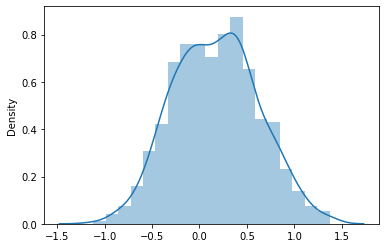

In [ ]:
print("Total number of  sample: {}".format(len(all_param_values)))
sns.distplot(all_param_values);

### Computing predictions

We will load the CIFAR-10 dataset and evaluate predictions on test data using one of the HMC samples. Please use a TPU or GPU runtime for this part of the colab.

In [ ]:
from jax import numpy as jnp
import numpy as onp

from bnn_hmc.utils import models
from bnn_hmc.utils import metrics
from bnn_hmc.utils import precision_utils
from bnn_hmc.utils import data_utils

Load the data and put it on the device.

In [ ]:
dtype = jnp.float32
train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
  "cifar10", dtype, truncate_to=None)

Load the model.

In [ ]:
net_apply, net_init = models.get_model("resnet20_frn_swish", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)

Load the parameters and network state.

In [ ]:
params, net_state = get_params_and_state(chain_id, sample_id)

We will evaluate the predictions on the first 100 test datapoints.

In [ ]:
num_inputs = 100

x_test, y_test = test_set
input, target = x_test[0, :num_inputs], y_test[0, :num_inputs]

The `net_apply` function has the following arguments:
- `params`
- `net_state`
- `rng` &mdash;  random number generator key, should be `None`
- `batch` &mdash; data to compute the prediction on, assumed to be `(x, y)` where `x` is the input and `y` is the target (`y` is not used and can be `None`)
- `is_training` whether to use train or test mode; this parameter has no effect on our architectures

It returns the network logits and updated `net_state`

In [ ]:
preds, _ = net_apply(params, net_state, None, (input, None), False)
preds = onp.asarray(preds)

Compute the accuracy of our predictions.

In [ ]:
print(metrics.accuracy(preds, target))

0.81
